# 📤 Notebook 4/6 — Predições no Conjunto de Teste e Submissão
## Ligia NLP Challenge — Detecção de Fake News

| Informação | Detalhe |
|---|---|
| **Entrada** | `data/processed/char_ngrams/tfidf_vectorizer_char_ngrams.joblib`, modelos em `models/mlclassico/` |
| **Saída** | `data/processed/submission_xgboost.csv`, `submission_linearsvc.csv`, `submission_ensemble_xgb_svc.csv` |
| **Notebook anterior** | `3.1-hyperparameter-optimization.ipynb` |
| **Próximo Notebook** | `5.0-tinybert.ipynb` (deep learning) |

## Objetivo
Gerar submissões individuais para os melhores modelos clássicos e depois combiná-los via ensemble.

## Pipeline
1. Carregar dados de teste limpos e vetorizador TF-IDF (char-ngrams)
2. Vetorizar conjunto de teste uma só vez
3. **[Independente]** Predições + submissão — **XGBoost nativo** (`model_1_xgboost.joblib`)
4. **[Independente]** Predições + submissão — **LinearSVC otimizado** (`linearsvc_optimized.joblib`)
5. Análise comparativa das predições (distribuição + concordância + discordâncias)
6. **Ensemble final** por votação → `submission_ensemble_xgb_svc.csv`

## Formato de saída esperado pelo Kaggle
```
id,target
5398,1
5503,0
...
```


## 1. Setup

In [5]:
import os, time, json
import warnings
warnings.filterwarnings('ignore')
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caminhos principais
MODEL_DIR     = '../models/mlclassico'
CHAR_DIR      = '../data/processed/char_ngrams'
OUTPUT_DIR    = '../data/processed'
FIGURES_DIR   = '../reports/figures'

os.makedirs(FIGURES_DIR, exist_ok=True)
print("✓ Setup concluído")


✓ Setup concluído


## 2. Carregar Dados de Teste e Vetorizador TF-IDF


In [6]:
# IDs originais (raw)
df_raw = pd.read_csv('../data/raw/test.csv')
ids = df_raw['id'].values

# Texto pré-processado (pipeline char-ngrams)
df_clean = pd.read_csv(os.path.join(CHAR_DIR, 'test_clean.csv'))
df_clean['title']     = df_clean['title'].fillna('')
df_clean['text']      = df_clean['text'].fillna('')
df_clean['full_text'] = df_clean['title'] + ' ' + df_clean['text']

assert len(ids) == len(df_clean), (
    f"Mismatch: {len(ids)} IDs vs {len(df_clean)} textos"
)

# Vetorizador TF-IDF char-ngrams (treinado no notebook 3.0)
vect_path  = os.path.join(CHAR_DIR, 'tfidf_vectorizer_char_ngrams.joblib')
vectorizer = joblib.load(vect_path)

print(f"✓ {len(df_clean):,} amostras de teste carregadas")
print(f"✓ Vetorizador TF-IDF carregado")
print(f"  vocab    : {len(vectorizer.vocabulary_):,} tokens")
print(f"  analyzer : {vectorizer.analyzer}")
print(f"  ngram    : {vectorizer.ngram_range}")


✓ 5,712 amostras de teste carregadas
✓ Vetorizador TF-IDF carregado
  vocab    : 50,000 tokens
  analyzer : char
  ngram    : (3, 5)


## 3. Vetorizar Dados de Teste


In [7]:
print("Vetorizando conjunto de teste...")
t0 = time.time()
X_test = vectorizer.transform(df_clean['full_text'])
elapsed = time.time() - t0

print(f"✓ Vetorização concluída em {elapsed:.2f}s")
print(f"  Shape: {X_test.shape[0]:,} docs × {X_test.shape[1]:,} features")


Vetorizando conjunto de teste...
✓ Vetorização concluída em 22.71s
  Shape: 5,712 docs × 50,000 features


## 4. Predições — XGBoost

Modelo base treinado no notebook 3.0 (`model_1_xgboost.joblib`). Obteve bom desempenho na validação e é o ponto de partida da submissão clássica.


In [8]:
xgb_path  = os.path.join(MODEL_DIR, 'char-ngrams-baseline', 'model_1_xgboost.joblib')
xgb_model = joblib.load(xgb_path)
print(f"✓ {type(xgb_model).__name__} carregado — {xgb_path}")

t0 = time.time()
preds_xgb = xgb_model.predict(X_test)
elapsed   = time.time() - t0

print(f"\n✓ Predições geradas em {elapsed:.2f}s")
print(f"\nDistribuição XGBoost:")
for cls, cnt in zip(*np.unique(preds_xgb, return_counts=True)):
    label = 'Fake' if cls == 1 else 'Real'
    print(f"  Classe {int(cls)} ({label}): {cnt:,}  ({cnt / len(preds_xgb):.1%})")

# Salvar submissão
xgb_sub_path = os.path.join(OUTPUT_DIR, 'submission_xgboost.csv')
pd.DataFrame({'id': ids, 'target': preds_xgb.astype(int)}).to_csv(xgb_sub_path, index=False)
print(f"\n✓ Submissão salva em: {xgb_sub_path}")


✓ XGBClassifier carregado — ../models/mlclassico\char-ngrams-baseline\model_1_xgboost.joblib

✓ Predições geradas em 0.03s

Distribuição XGBoost:
  Classe 0 (Real): 4,281  (74.9%)
  Classe 1 (Fake): 1,431  (25.1%)

✓ Submissão salva em: ../data/processed\submission_xgboost.csv


## 5. Predições — LinearSVC Otimizado

Modelo com hiperparâmetros ajustados no notebook 3.1 (`linearsvc_optimized.joblib`). 


In [9]:
svc_path  = os.path.join(MODEL_DIR, 'optimized', 'linearsvc_optimized.joblib')
svc_model = joblib.load(svc_path)
print(f"✓ {type(svc_model).__name__} carregado — {svc_path}")

t0 = time.time()
preds_svc = svc_model.predict(X_test)
elapsed   = time.time() - t0

print(f"\n✓ Predições geradas em {elapsed:.2f}s")
print(f"\nDistribuição LinearSVC:")
for cls, cnt in zip(*np.unique(preds_svc, return_counts=True)):
    label = 'Fake' if cls == 1 else 'Real'
    print(f"  Classe {int(cls)} ({label}): {cnt:,}  ({cnt / len(preds_svc):.1%})")

# Salvar submissão
svc_sub_path = os.path.join(OUTPUT_DIR, 'submission_linearsvc.csv')
pd.DataFrame({'id': ids, 'target': preds_svc.astype(int)}).to_csv(svc_sub_path, index=False)
print(f"\n✓ Submissão salva em: {svc_sub_path}")


✓ CalibratedClassifierCV carregado — ../models/mlclassico\optimized\linearsvc_optimized.joblib

✓ Predições geradas em 0.11s

Distribuição LinearSVC:
  Classe 0 (Real): 4,286  (75.0%)
  Classe 1 (Fake): 1,426  (25.0%)

✓ Submissão salva em: ../data/processed\submission_linearsvc.csv


## 6. Análise das Predições Independentes

Comparação das distribuições e taxa de concordância entre XGBoost e LinearSVC antes de montar o ensemble.


  CONCORDÂNCIA XGBoost × LinearSVC
  Total de amostras : 5,712
  Concordam         : 5,707  (99.9%)
  Discordam         : 5  (0.1%)

Padrão das discordâncias (xgb  →  svc):
 xgb  svc  count
   1    0      5


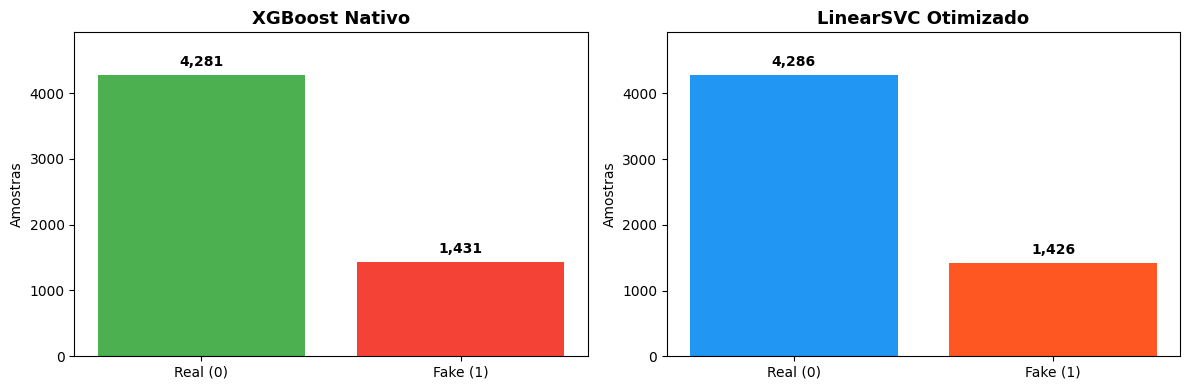

✓ Figura salva em: ../reports/figures\predictions_comparison.png


In [13]:
# DataFrame consolidado de predições
pred_df = pd.DataFrame({
    'id'  : ids,
    'xgb' : preds_xgb.astype(int),
    'svc' : preds_svc.astype(int),
})

agree_mask = pred_df['xgb'] == pred_df['svc']
n_agree    = int(agree_mask.sum())
n_disagree = int((~agree_mask).sum())
pct_agree  = n_agree / len(pred_df)

print("=" * 55)
print("  CONCORDÂNCIA XGBoost × LinearSVC")
print("=" * 55)
print(f"  Total de amostras : {len(pred_df):,}")
print(f"  Concordam         : {n_agree:,}  ({pct_agree:.1%})")
print(f"  Discordam         : {n_disagree:,}  ({1 - pct_agree:.1%})")
print()
print("Padrão das discordâncias (xgb  →  svc):")
print(pred_df[~agree_mask].groupby(['xgb', 'svc']).size()
      .rename('count').reset_index().to_string(index=False))

# ── Plots ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (col, label, color_pair) in zip(axes, [
    ('xgb', 'XGBoost Nativo',      ['#4CAF50', '#F44336']),
    ('svc', 'LinearSVC Otimizado', ['#2196F3', '#FF5722']),
]):
    counts = pred_df[col].value_counts().sort_index()
    bars = ax.bar(['Real (0)', 'Fake (1)'], counts.values, color=color_pair)
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.set_ylabel('Amostras')
    ax.set_ylim(0, counts.max() * 1.15)
    for b, v in zip(bars, counts.values):
        ax.text(b.get_x() + b.get_width() / 2,
                b.get_height() + counts.max() * 0.02,
                f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
fig_path = os.path.join(FIGURES_DIR, 'predictions_comparison.png')
plt.savefig(fig_path, dpi=120, bbox_inches='tight')
plt.show()
print(f"✓ Figura salva em: {fig_path}")


## 7. Ensemble Final — XGBoost + LinearSVC

**Estratégia de votação (2 modelos):**
- Quando os dois **concordam** → usa a predição diretamente
- Quando **discordam** → o **LinearSVC desempata** (wins)


In [15]:
# Ensemble: onde concordam usa predição direta; onde discordam LinearSVC wins
ensemble_preds = np.where(agree_mask.values, pred_df['xgb'].values, pred_df['svc'].values)

ensemble_path = os.path.join(OUTPUT_DIR, 'submission_ensemble_xgb_svc_svc_wins.csv')
pd.DataFrame({'id': ids, 'target': ensemble_preds.astype(int)}).to_csv(ensemble_path, index=False)

# ── Relatório final ────────────────────────────────────────────────────
print("=" * 55)
print("  ENSEMBLE FINAL — XGBoost + LinearSVC (SVC wins)")
print("=" * 55)
print(f"\n  Amostras com consenso     : {n_agree:,}  ({pct_agree:.1%})")
print(f"  Amostras com desempate    : {n_disagree:,}  ({1 - pct_agree:.1%})  → LinearSVC decide")
print(f"\nDistribuição do Ensemble:")
for cls, cnt in zip(*np.unique(ensemble_preds, return_counts=True)):
    label = 'Fake' if cls == 1 else 'Real'
    print(f"  Classe {int(cls)} ({label}): {cnt:,}  ({cnt / len(ensemble_preds):.1%})")

print(f"\n✅ Submissão ensemble salva em: {ensemble_path}")


  ENSEMBLE FINAL — XGBoost + LinearSVC (SVC wins)

  Amostras com consenso     : 5,707  (99.9%)
  Amostras com desempate    : 5  (0.1%)  → LinearSVC decide

Distribuição do Ensemble:
  Classe 0 (Real): 4,286  (75.0%)
  Classe 1 (Fake): 1,426  (25.0%)

✅ Submissão ensemble salva em: ../data/processed\submission_ensemble_xgb_svc_svc_wins.csv
